### Mounting your google drive on Colab Noetebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## remplazá 'unqml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/unqml/ML_UNQ2020/ 

In [1]:
#%cd ../

/home/ariel/repos/ML_UNQ2020


In [2]:
import src.utility_functions as uf   ## cargo funciones
# data manipulation
import pandas as pd
import numpy as np
from operator import itemgetter


## learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

## preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


### model performance
from sklearn import metrics

#ploting modules
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

## Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV


## además cargo funciones específicas para este notebook
try:
    import category_encoders as ce
except:
    !pip install category_encoders


from sklearn.model_selection import cross_val_score

## Para guardar y levantar un objeto en pickle (ej. resultados de un gridsearch intensivo)
import joblib as jlb


## Hyperparameter optimization
from sklearn.model_selection import GridSearchCV

try:
    import shap
except:
    !pip install shap
    import shap



In [73]:
SEED = 2718281


# normed expression data
expr_data = pd.read_csv('./data/AMLdataset/data/GSE13425_Norm_Whole.tab',sep = '\t')
expr_data.rename(columns = {'Unnamed: 0':'gene'},inplace =True)
expr_data.set_index('gene',inplace =True)

#phenotype data
pheno_data = pd.read_csv('./data/AMLdataset/data/phenoData_GSE13425.tab',sep ='\t')
pheno_data['simple_target'] = 0

targetcolumn = 'simple_target'

# construyo target binario
pheno_data.loc[pheno_data['sample.labels']=='Bo',targetcolumn] = 1
pheno_data.loc[pheno_data['sample.labels']!='Bo',targetcolumn] = 0


merged = pd.merge(expr_data.transpose(),pheno_data[['Sample.GEO.ID',targetcolumn]],
                  left_index=True,right_on=['Sample.GEO.ID']).set_index(['Sample.GEO.ID'])

X = merged.drop(targetcolumn,axis = 1).copy(); y = merged[[targetcolumn]].copy()

y[targetcolumn].value_counts(dropna=False)

0    146
1     44
Name: simple_target, dtype: int64

In [87]:
## train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED,stratify = y)
Y_train = y_train[targetcolumn].ravel()
Y_test = y_test[targetcolumn].ravel()


In [88]:
# Load data and define preprocessing
## el preprocesamiento sólo con variables continuas
preprocessor = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))])  # Esto es una vacancia de Sklearn, no permite aún "centrar" matrizes sparse




In [89]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',RandomForestClassifier(random_state = SEED,n_estimators = 50))])  


In [92]:
rfcv = cross_val_score(pipeline, X_train, Y_train, cv=5,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.6650867163206835 0.05655457027259522


## Explorarción de hiperparámetros
Ver:

__[Acá, exploración individual](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/)__

### Numero de estimadores (árboles)

In [117]:
name = 'n_estimators'


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


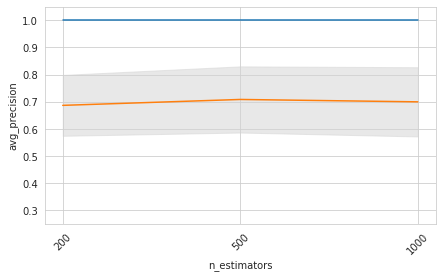

In [120]:
name = 'n_estimators'
value_range = np.array([200,500,1000])
value_range = [int(v) for v in value_range]

gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)


matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,
                      grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')


In [99]:
pipeline.fit(X_train,Y_train)
pipeline

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('num_imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='median', verbose=0)),
                                 ('scaler',
                                  StandardScaler(copy=True, with_mean=False,
                                                 with_std=True))],
                          verbose=False)),
                ('clasificador',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                            

.

### Max features

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


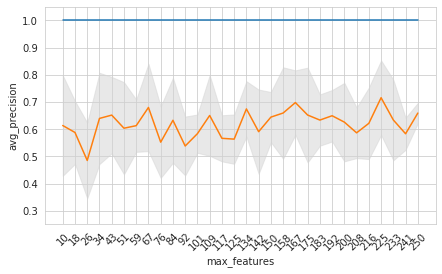

In [121]:
name = 'max_features'
value_range = np.linspace(10, 250, 30, endpoint=True)
value_range = [int(v) for v in value_range]
## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


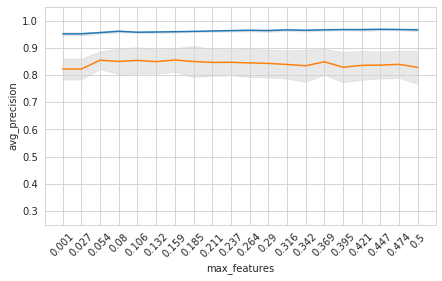

In [72]:
pipeline.named_steps['clasificador'].set_params(**{'min_samples_split':0.05})
name = 'max_features'
value_range = np.linspace(0.001, 0.5, 20, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

### Máxima profundiad del arbol admitida (Max Depth)
Otro que controla complegidad. 

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


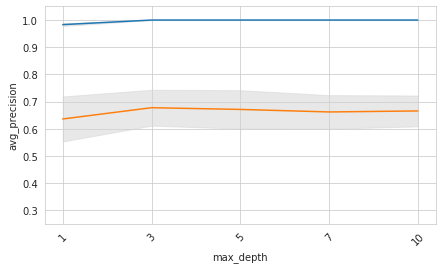

In [122]:
name = 'max_depth'

value_range = np.linspace(1, 10, 5, endpoint=True)
value_range = [int(m) for m in value_range]  # esto no es necesario, sólo está acá por cómo estamos ploteando



## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

## minimal Impurity of leafs

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


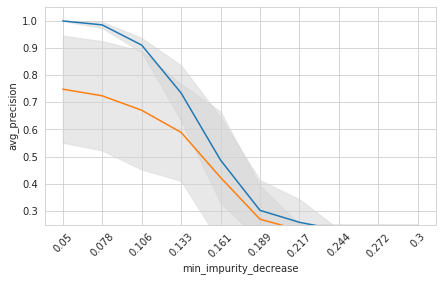

In [126]:
name = 'min_impurity_decrease'

value_range  = np.linspace(0.05,0.3, 10, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=10,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

### GridSearch

In [76]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',RandomForestClassifier(random_state = SEED, n_estimators=50))]) 

min_samples_splits = np.linspace(0.05, 0.2, 5, endpoint=True)
max_depths = np.linspace(3, 9, 7, endpoint=True)
max_features= np.linspace(0.1, 0.5, 5, endpoint=True)

param_grid = [
  {
      'clasificador__min_samples_split':min_samples_splits,
      'clasificador__max_depth':max_depths,
      'clasificador__max_features':max_features
#      'clasificador__min_impurity_decrease':min_impurity_decrease
  }
 ]
search = GridSearchCV(pipeline, param_grid, 
                      cv=10,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [77]:
print('performance best classif %.4f'%search.best_score_)
print('best hyperparameters: \n')

print(search.best_params_)

aux= cross_val_score(search.best_estimator_, X_train, Y_train, cv=10,scoring = 'average_precision')
print(np.mean(aux),np.std(aux))

print(metrics.average_precision_score(Y_test,search.best_estimator_.predict_proba(X_test)[:,1]))


performance best classif 0.8642
best hyperparameters: 

{'clasificador__max_depth': 8.0, 'clasificador__max_features': 0.1, 'clasificador__min_samples_split': 0.05}
0.8640011660434507 0.07154812137847703
0.8101892720748515


In [85]:
metrics.average_precision_score(Y_test,search.best_estimator_.predict_proba(X_test)[:,1])


0.8101892720748515

In [84]:
rfcv = cross_val_score(search.best_estimator_, X_train, Y_train, cv=10,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.8640011660434507 0.07154812137847703


In [83]:
rfcv = cross_val_score(pipeline, X_train, Y_train, cv=10,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.8660899902070425 0.07076323190154747


In [89]:
pipe2 = search.best_estimator_
pipe2.named_steps['clasificador'].set_params(**{'n_estimators':500})
rfcv = cross_val_score(pipe2, X_train, Y_train, cv=10,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.86750460847968 0.07805236300137115


In [6]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',RandomForestClassifier(random_state = SEED,n_estimators = 2000))])  

rfcv = cross_val_score(pipeline, X_train, Y_train,  cv=10,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.8878599634958398 0.06962159151249707


In [7]:
pipeline = pipeline.fit(X_train,Y_train)

In [8]:
metrics.average_precision_score(Y_test,pipeline.predict_proba(X_test)[:,1])

0.841860914040701

## Les dejo este post con algo de info de F.I en RF más allá del default basado en Out of Bag

__[Acá, algo de Feature Importance en RF](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)__

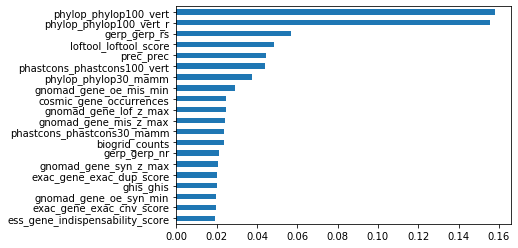

In [12]:
numerical_names = pipeline.named_steps['preprocessing'].transformers[0][2]
categorical_output_names = pipeline.named_steps['preprocessing'].named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()

cols = numerical_names + categorical_output_names

fig, ax = plt.subplots(1)
matplotlib.rcParams['figure.figsize'] = [10, 8]
clf = pipeline.named_steps['clasificador']
fi = pd.Series(clf.feature_importances_,index = cols )
s = fi.sort_values(ascending =False)[0:20]
s.sort_values(ascending =True).plot.barh()



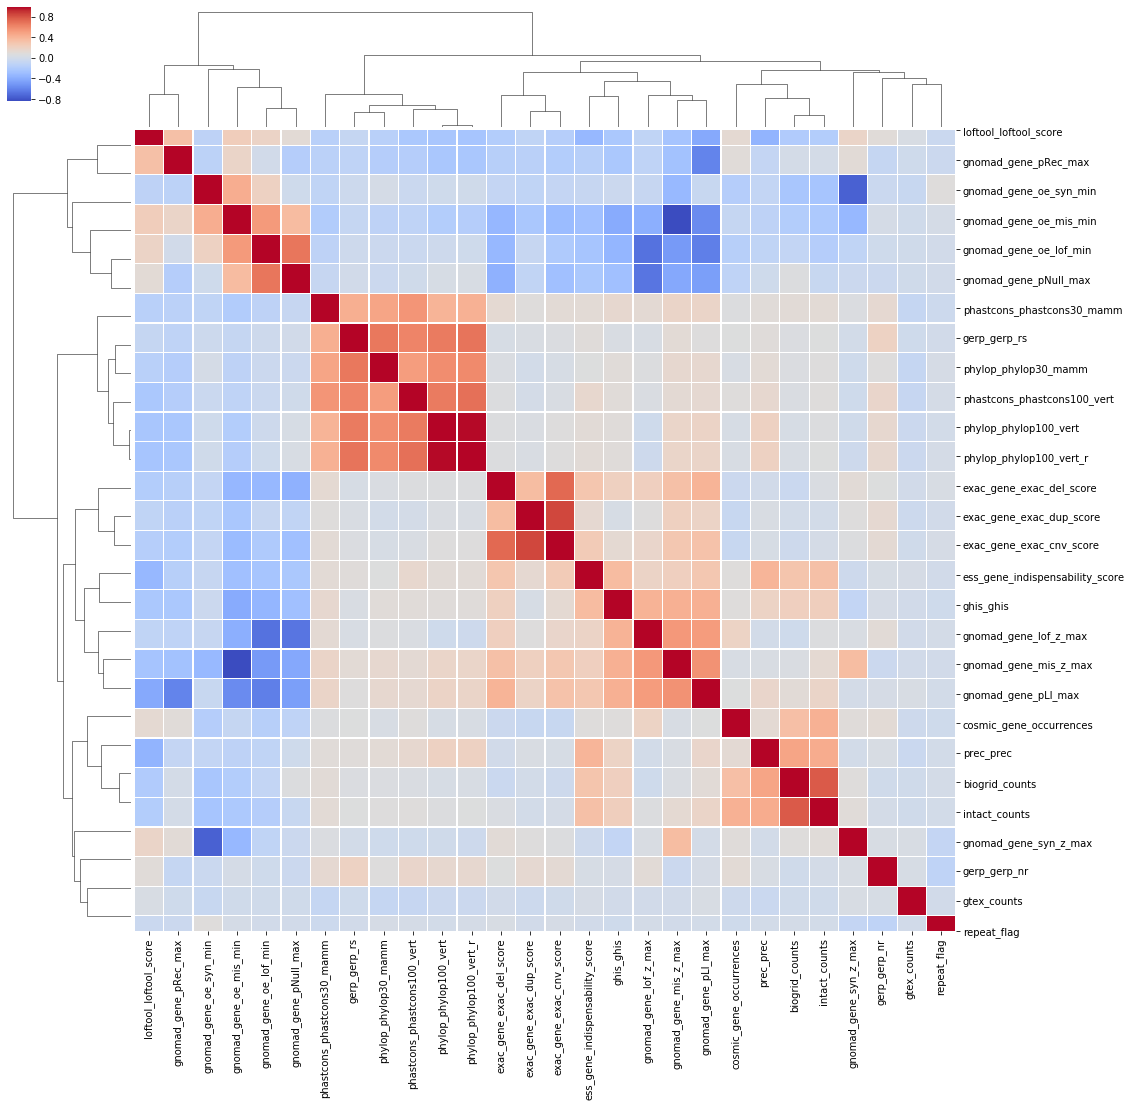

In [13]:
corr = X_train.corr()

cg = sns.clustermap(corr.fillna(0), cmap ='coolwarm', linewidths = 0.2,
                    method = 'complete', xticklabels=1,figsize = (17,17)) 
cg

In [14]:
from sklearn.cluster import AgglomerativeClustering

corr_thr = 0.4
ccols = corr.columns
cluster = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                                  linkage='complete',distance_threshold=1-corr_thr)
etiquetas = cluster.fit_predict(1-abs(corr))
cldf = pd.DataFrame({'feature':corr.columns,'clusterID':etiquetas})
res = dict(zip(corr.columns, etiquetas)) 

feat =[]
for e in np.unique(etiquetas):
    i = etiquetas == e
    f = ccols[i]
    feat.append(list(f))
feat

[['ghis_ghis', 'gnomad_gene_oe_mis_min', 'gnomad_gene_mis_z_max'],
 ['gnomad_gene_pLI_max', 'gnomad_gene_pRec_max'],
 ['gerp_gerp_rs',
  'phastcons_phastcons100_vert',
  'phastcons_phastcons30_mamm',
  'phylop_phylop100_vert',
  'phylop_phylop100_vert_r',
  'phylop_phylop30_mamm'],
 ['gnomad_gene_oe_syn_min', 'gnomad_gene_syn_z_max'],
 ['gnomad_gene_oe_lof_min', 'gnomad_gene_lof_z_max', 'gnomad_gene_pNull_max'],
 ['loftool_loftool_score'],
 ['prec_prec', 'biogrid_counts', 'intact_counts'],
 ['repeat_flag'],
 ['exac_gene_exac_dup_score', 'exac_gene_exac_cnv_score'],
 ['gerp_gerp_nr'],
 ['cosmic_gene_occurrences'],
 ['gtex_counts'],
 ['ess_gene_indispensability_score'],
 ['exac_gene_exac_del_score']]

In [15]:
cldf.sort_values(by='clusterID').head(15)

,feature,clusterID
20,gnomad_gene_oe_mis_min,0
23,gnomad_gene_mis_z_max,0
11,ghis_ghis,0
25,gnomad_gene_pLI_max,1
26,gnomad_gene_pRec_max,1
1,gerp_gerp_rs,2
2,phastcons_phastcons100_vert,2
3,phastcons_phastcons30_mamm,2
4,phylop_phylop100_vert,2
5,phylop_phylop100_vert_r,2


In [16]:
from rfpimp import permutation_importances, importances, plot_importances

def avPrec(model, X, y,sample_weight=None):
    return metrics.average_precision_score(y_true = y, y_score = model.predict(X),sample_weight =sample_weight)


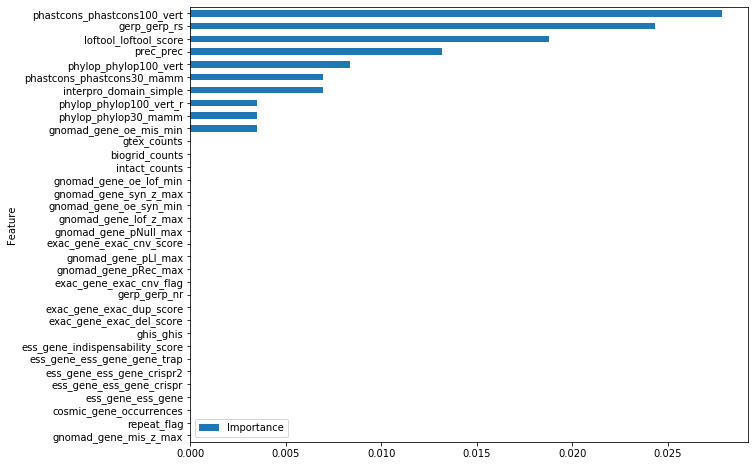

In [17]:
I0 =   importances(pipeline, X_train, y_train, metric = avPrec)
#plot_importances(I0,width=25)
I0.sort_values(by='Importance',ascending=True).plot.barh()

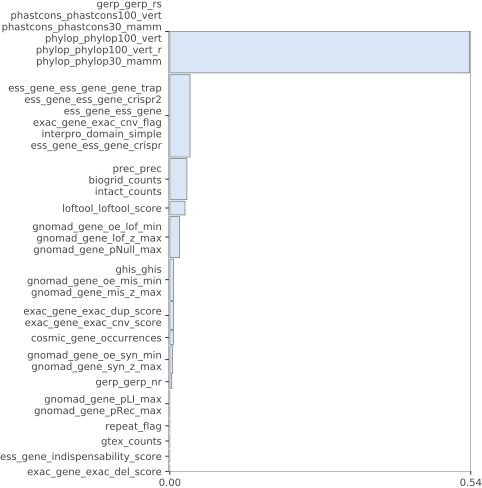

In [18]:
Iclust = importances(pipeline, X_train, y_train, metric= avPrec,features=feat,n_samples=-1)
plot_importances(Iclust,width=7)

### Podemos verlo en en test set

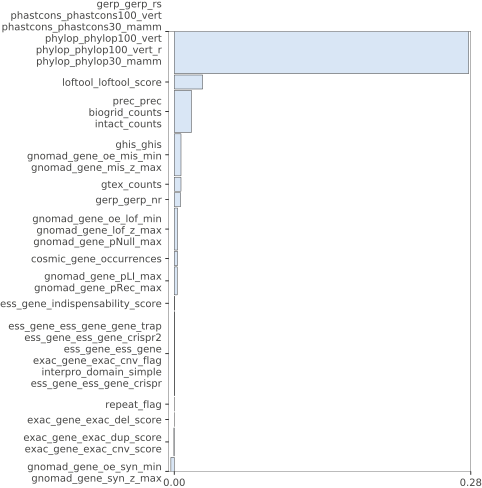

In [19]:
Iclust = importances(pipeline, X_test, y_test, metric= avPrec,features=feat,n_samples=-1)
plot_importances(Iclust,width=7)

## Esto es de los tipos de rfpimp:

(como lectura complementaria, y a absorber con espíritu crítico)

__[Explained AI (de los creadores de rfpimp)](https://explained.ai/rf-importance/index.html#5)__


.

## Shapely

In [9]:
import shap
#import lime ### hay que verlo (e instalarlo)

In [10]:
pp = pipeline.named_steps['preprocessing']
model = pipeline.named_steps['clasificador']

In [15]:
Xprep = pp.transform(X_train)
Xprep = pd.DataFrame(Xprep)  # preproceso para que SHAP pueda perturbar sin nulls

# recupero nombre de columnas
numerical_names = pp.transformers_[0][2]
categorical_output_names = pp.named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
cols = numerical_names + categorical_output_names
Xprep.columns = cols

Xtrain_sampled = shap.sample(Xprep,200)

In [ ]:
shap_tree_explainer = shap.TreeExplainer(model, Xtrain_sampled,model_output = 'probability')
shap_values = shap_tree_explainer.shap_values(Xtrain_sampled)

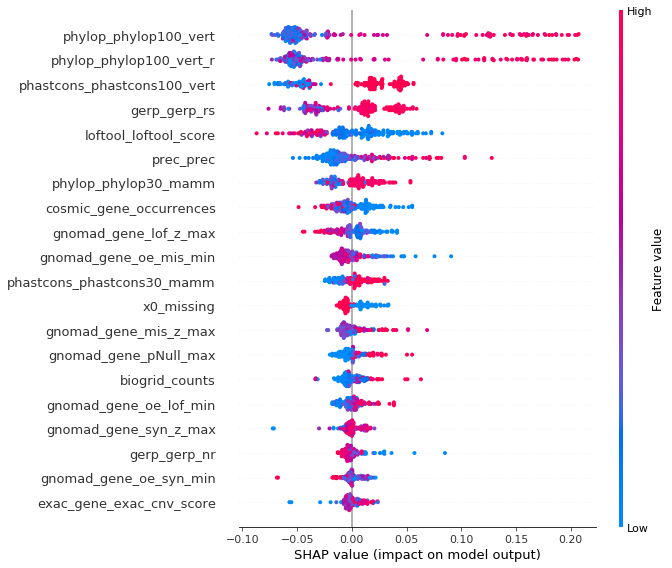

In [39]:
shap.summary_plot(shap_values[1], Xtrain_sampled, plot_type="dot")

### Interaction plots 
* para entender valor predictivo conjunto de grupos de dos variables

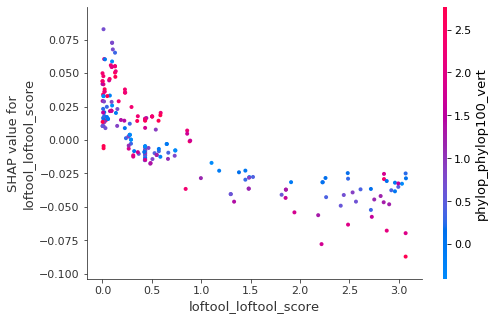

In [18]:
shap.dependence_plot('loftool_loftool_score', shap_values[1], Xtrain_sampled)

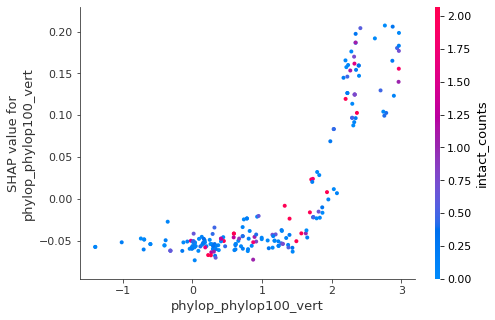

In [19]:
shap.dependence_plot('phylop_phylop100_vert', shap_values[1], Xtrain_sampled)

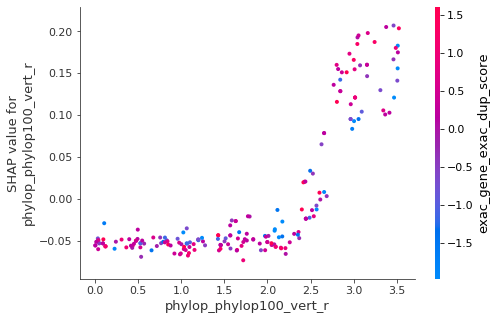

In [74]:
shap.dependence_plot("rank(1)",shap_values[1], Xtrain_sampled)

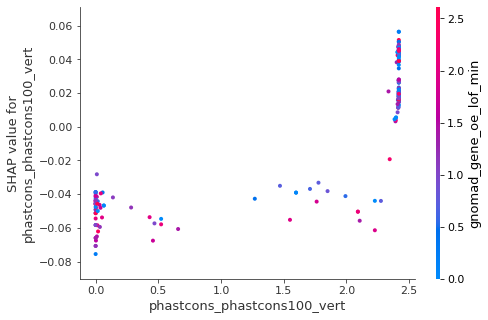

In [54]:
shap.dependence_plot(ind = "rank(2)",shap_values = shap_values[1], 
                     features = Xtrain_sampled,interaction_index = "gnomad_gene_oe_lof_min")

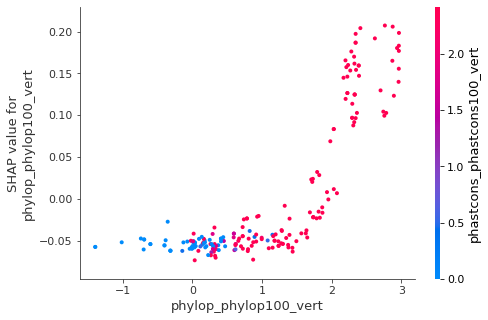

In [55]:
shap.dependence_plot(ind = 'phylop_phylop100_vert',shap_values = shap_values[1], 
                     features = Xtrain_sampled,interaction_index = 'phastcons_phastcons100_vert')

### Explicando predicciones localmente (a nivel de ítem individual) 
Ojo q es costoso en cálculo

In [45]:
shap.initjs()

In [79]:
#Y_train[Xtrain_sampled.index].mean()
Xtrain_sampled.mean().loc[['gnomad_gene_syn_z_max','gnomad_gene_oe_syn_min',
                           'biogrid_counts','phylop_phylop100_vert'],]


gnomad_gene_syn_z_max    -0.399396
gnomad_gene_oe_syn_min    4.852250
biogrid_counts            0.378041
phylop_phylop100_vert     1.064644
dtype: float64

In [ ]:
def localplot(j,tree_explainer=shap_tree_explainer,shapValues=shap_values,X=Xtrain_sampled):
    return shap.force_plot(tree_explainer.expected_value[1], shapValues[1][j],X.iloc[[j]])

In [103]:
shap_tree_explainer.

<bound method TreeExplainer.shap_interaction_values of <shap.explainers.tree.TreeExplainer object at 0x7f2160caec18>>

In [84]:
j=2
print('original class: %s'%Y_train[Xtrain_sampled.index][j])

localplot(j)

original class: 0


### Recordar que SHAP ES ADITIVO:
* expected + sum(contributions) = model output value

In [118]:
# para el segundo ítem (j = 2)
shap_tree_explainer.expected_value[1] + shap_values[1].sum(axis=1)[j]

0.08392249096807292

#### (notar que ese valor, 0.08 coincide con el gráfico)

## Veamos otro ejemplo, una variante patogénica

In [119]:
j=3
print('original class: %s'%Y_train[Xtrain_sampled.index][j])

localplot(j)

original class: 1


## Distribución de shap output values

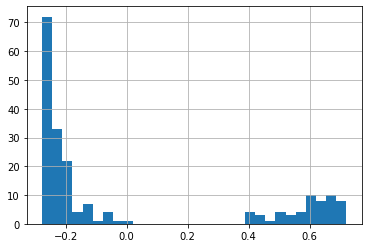

In [162]:
output_values = shap_tree_explainer.expected_value[1] + shap_values[1].sum(axis=1)
classified_as_possitive  = output_values - shap_tree_explainer.expected_value[1]

pd.Series(shap_values[1].sum(axis = 1)).hist(bins = 30)

In [183]:
#shap_tree_explainer = shap.TreeExplainer(model, Xtrain_sampled, feature_perturbation = "tree_path_dependent",model_output = 'raw')
#interaction_values = shap_tree_explainer.shap_interaction_values(Xtrain_sampled)[1]
#shap.decision_plot(shap_tree_explainer.expected_value[1],
#                   interaction_values[1,:,:],feature_names=cols)